In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def generate_sample_data(num, seed=0):
    target_list = [] # 目的変数のリスト
    feature_vector_list = [] # 説明変数（特徴量）のリスト

    feature_num = 8 # 特徴量の数
    intercept = 0.2 # 切片
    weight = [0.2, 0.3, 0.5, -0.4, 0.1, 0.2, 0.5, -0.3] # 各特徴量の重み

    np.random.seed(seed=seed)
    for i in range(num):
        feature_vector = [np.random.rand() for n in range(feature_num)] # 特徴量をランダムに生成
        noise = [np.random.normal(0, 0.1) for n in range(feature_num)] # ノイズをランダムに生成
        target = sum([intercept+feature_vector[n]*weight[n]+noise[n] for n in range(feature_num)]) # 目的変数を生成

        target_list.append(target)
        feature_vector_list.append(feature_vector)

    df = pd.DataFrame(np.c_[target_list, feature_vector_list], 
                      columns=['target', 'feature0', 'feature1', 'feature2', 
                               'feature3', 'feature4', 'feature5', 'feature6', 'feature7'])
    return df

data = generate_sample_data(num=1000, seed=0)

X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
import pystan
import arviz

In [4]:
sample_code = """
    data {
        int<lower=0> N;
        int<lower=0> D;
        matrix[N, D] X;
        vector[N] y;
        int<lower=0> N_new;
        matrix[N_new, D] X_new;
    }
    parameters {
        real w0;
        vector[D] w;
        real<lower=0> sigma;
    }
    model {
        for (i in 1:N)
            y[i] ~ normal(w0 + dot_product(X[i], w), sigma);
    }
    generated quantities {
        vector[N_new] y_new;
        for (i in 1:N_new)
            y_new[i] = normal_rng(w0 + dot_product(X_new[i], w), sigma);
    }
"""

sample_data = {
    'N': X_train.shape[0],
    'D': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_new': X_test.shape[0],
    'X_new': X_test
}


In [19]:
sm = pystan.StanModel(model_code=sample_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_92cd13fa4b6e158fdf4f4ede934e6196 NOW.


In [21]:
%%time
fit = sm.sampling(data=sample_data, iter=10, chains=2, n_jobs=-1)

KeyboardInterrupt: 

array([[<AxesSubplot:title={'center':'w0'}>,
        <AxesSubplot:title={'center':'w0'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'y_new'}>,
        <AxesSubplot:title={'center':'y_new'}>]], dtype=object)

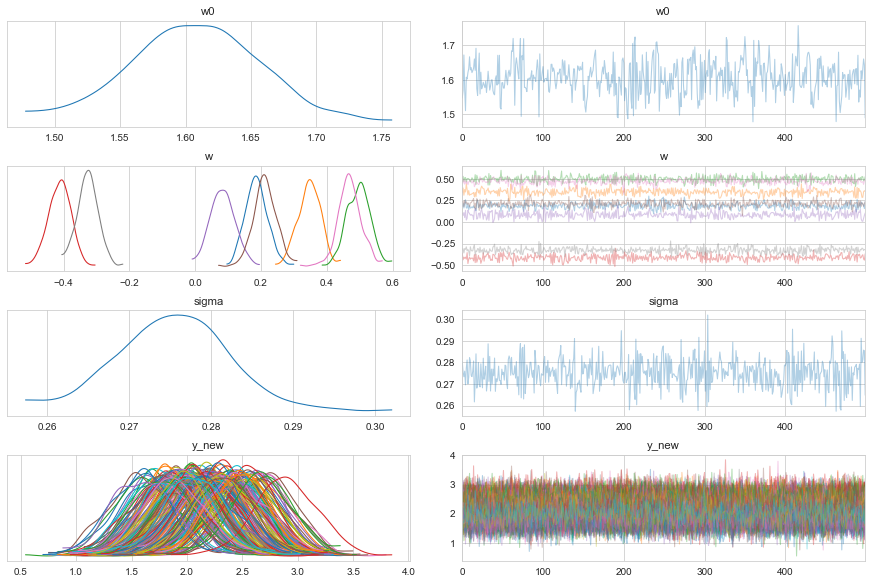

In [14]:
arviz.plot_trace(fit)

In [10]:
y_pred = fit['y_new'].mean(axis=0)
print('MSE(test) = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('R^2(test) = {:.2f}'.format(r2_score(y_test, y_pred)))

MSE(test) = 18.69
R^2(test) = -127.97


In [18]:
import stan

ModuleNotFoundError: No module named 'stan'